# Urban Greenspace and Asthma Prevalence

### Get Started with Big Data Pipelines

Vegetation has the potential to provide many ecosystem services in urban areas, such as cleaner air and water and flood mitigation. However, the results are mixed on relationships between a simple measurement of vegetation cover (such as average NDVI, a measurement of vegetation health) and human health. We do, however, find relationships between landscape metrics that attempt to quantify the connectivity and structure of greenspace and human health. These types of metrics include mean patch size, edge density, and fragmentation.

In this notebook, you will write code to calculate patch, edge, and fragmentation statistics about urban greenspace in Chicago. These statistics should be reflective of the connectivity and spread of urban greenspace, which are important for ecosystem function and access. You will then use a linear model to identify statistically significant correlations between the distribution of greenspace and health data compiled by the US Center for Disease Control.

#### Read More
Check out this study by [Tsai et al. 2019](https://doi.org/10.1007/s11252-018-0813-3) on the relationship between edge density and life expectancy in Baltimore, MD. The authors also discuss the influence of scale (e.g. the resolution of the imagery) on these relationships, which is important for this case study.

Full citation: Tsai, Wei-Lun, Yu-Fai Leung, Melissa R. McHale, Myron F. Floyd, and Brian J. Reich. 2019. “Relationships Between Urban Green Land Cover and Human Health at Different Spatial Resolutions.” *Urban Ecosystems* 22 (2): 315–24. https://doi.org/10.1007/s11252-018-0813-3.

### Working with larger-than-memory (big) data

For this project, we are going to split up the green space (NDVI) data
by census tract, because this matches the human health data from the
CDC. If we were interested in the average NDVI at this spatial scale, we
could easily use a source of multispectral data like Landsat (30m) or
even MODIS (250m) without a noticeable impact on our results. However,
because we need to know more about the structure of green space within
each tract, we need higher resolution data. For that, we will access the
National Agricultural Imagery Program (NAIP) data, which is taken for
the continental US every few years at 1m resolution. That’s enough to
see individual trees and cars! The main purpose of the NAIP data is, as
the name suggests, agriculture. However, it’s also a great source for
urban areas where lots is happening on a very small scale.

The NAIP data for the City of Chicago takes up about 20GB of space. This
amount of data is likely to crash your kernel if you try to load it all
in at once. It also would be inconvenient to store on your harddrive so
that you can load it in a bit at a time for analysis. Even if you are
using a computer that would be able to handle this amount of data,
imagine if you were analysing the entire United States over multiple
years!

To help with this problem, you will use cloud-based tools to calculate
your statistics instead of downloading rasters to your computer or
container. You can crop the data entirely in the cloud, thereby saving
on your memory and internet connection, using `rioxarray`.

### Check your work with testing!

This notebook does not have pre-built tests. You will need to write your
own test code to make sure everything is working the way that you want.
For many operations, this will be as simple as creating a plot to check
that all your data lines up spatially the way you were expecting, or
printing values as you go. However, if you don’t test as you go, you are
likely to end up with intractable problems with the final code.

## STEP 1: Set up your analysis

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><p>As always, before you get started:</p>
<ol type="1">
<li>Import necessary packages</li>
<li>Create <strong>reproducible file paths</strong> for your project
file structure.</li>
<li>To use cloud-optimized GeoTiffs, we recommend some settings to make
sure your code does not get stopped by a momentary connection lapse –
see the code cell below.</li>
</ol></div></div>

In [99]:
### Import libraries

## for organization 
import os
import pathlib 
import warnings #to see warnings

#for the data analysis

import pandas as pd #for tabular data
import geopandas as gpd #for shapefiles
import numpy as np #for array computations
import xarray as xr 
import rioxarray as rxr #for raster data
import rioxarray.merge as rxrmerge #to mosiac the different raster files 
import shapely #to work with geometries
import time #to work with dates and such

## for plots and visualizing
import geoviews as gv #to see geographic data
import holoviews as hv #for visualizing data
import hvplot.pandas #to plot vector data
import hvplot.xarray
from cartopy import crs as ccrs

## for data exploration
import matplotlib
import scipy.stats as stats
import matplotlib.pyplot as plt

### for images
from scipy.ndimage import convolve
from scipy.ndimage import label

## for working with data in the cloud
import pystac_client
from sodapy import Socrata

## for progess visualization
from tqdm.auto import tqdm

## OLS sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [100]:
### Create reproducible file paths
data_dir = os.path.join(
    ## home directory
    pathlib.Path.home(),

    ## Earth analytics folder
    'earth-analytics',
    'data',

    ## porject directory
    'urban-green-big-data'
)

os.makedirs(data_dir, exist_ok= True)


In [101]:
### revent GDAL from quitting due to momentary disruptions
os.environ["GDAL_HTTP_MAX_RETRY"] = "5"
os.environ["GDAL_HTTP_RETRY_DELAY"] = "1"

## STEP 2: Create a site map

We’ll be using the Center for Disease Control (CDC) Places dataset for
human health data to compare with vegetation metrics. CDC Places also provides
some modified census tracts, clipped to the city boundary, to go along
with the health data. We’ll start by downloading the matching geographic
data, and then select the City of Chicago.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>Download the Census tract Shapefile that goes along with CDC
Places</li>
<li>Use a <strong>row filter</strong> to select only the census tracts
in Chicago</li>
<li>Use a <strong>conditional statement</strong> to cache your download.
There is no need to cache the full dataset – stick with your pared down
version containing only Chicago.</li>
</ol></div></div>


In [102]:
### Set up the census tract path

## defining my directory
tract_dir = os.path.join(data_dir, 'chicago-tract')

## make it
os.makedirs(tract_dir, exist_ok= True)

## make path to directory
tract_path = os.path.join(tract_dir, 'chicago-tract.shp')


### Download the census tracts (only once)
if not os.path.exists(tract_path):

    ##put in cenus url
    tract_url = ('https://data.cdc.gov/download/x7zy-2xmx/application%2Fzip')

    ## read the shape file
    tract_gdf = gpd.read_file(tract_url)

    ##subset to Chicago
    chi_tract_gdf = tract_gdf[tract_gdf.PlaceName =='Chicago']

    ## save it as a file

    chi_tract_gdf.to_file(tract_path, index = False)

### Load in census tract data
chi_tract_gdf = gpd.read_file(tract_path)
chi_tract_gdf

### Site plot -- Census tracts with satellite imagery in the background
(
    chi_tract_gdf

    ## set projection
    .to_crs(ccrs.Mercator())

    #plot with satellite imagery in the background
    .hvplot(
        line_color = 'orange', fill_color = None,
        crs = ccrs.Mercator(), tiles = 'EsriImagery',
        frame_width = 600
    )


)


:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-respond"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Reflect and Respond</div></div><div class="callout-body-container callout-body"><p>What do you notice about the City of Chicago from the coarse
satellite image? Is green space evenly distributed? What can you learn
about Chicago from websites, scientific papers, or other resources that
might help explain what you see in the site map?</p></div></div>

**WRITE YOUR CITY OF CHICAGO DATA DESCRIPTION AND CITATION HERE**

## STEP 3 - Access Asthma and Urban Greenspaces Data

### Step 3a - Access human health data

The U.S. Center for Disease Control (CDC) provides a number of health
variables through their [Places
Dataset](https://www.cdc.gov/places/index.html) that might be correlated
with urban greenspace. For this assignment, start with adult asthma. Try
to limit the data as much as possible for download. Selecting the state
and county is a one way to do this.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>You can access Places data with an API, but as with many APIs it is
easier to test out your search before building a URL. Navigate to the <a
href="https://data.cdc.gov/500-Cities-Places/PLACES-Local-Data-for-Better-Health-Census-Tract-D">Places
Census Tract Data Portal</a> and search for the data you want.</li>
<li>The data portal will make an API call for you, but there is a
simpler, easier to read and modify way to form an API call. Check out to
the <a href="https://dev.socrata.com/docs/endpoints">socrata
documentation</a> to see how. You can also find some limited examples
and a list of available parameters for this API on <a
href="https://dev.socrata.com/foundry/data.cdc.gov/cwsq-ngmh">CDC Places
SODA Consumer API Documentation</a>.</li>
<li>Once you have formed your query, you may notice that you have
exactly 1000 rows. The Places SODA API limits you to 1000 records in a
download. Either narrow your search or check out the
<code>&amp;$limit=</code> parameter to increase the number of rows
downloaded. You can find more information on the <a
href="https://dev.socrata.com/docs/paging">Paging page of the SODA API
documentation</a></li>
<li>You should also clean up this data by renaming the
<code>'data_value'</code> to something descriptive, and possibly
selecting a subset of columns.</li>
</ol></div></div>

In [103]:
### Set up a path for the asthma data
cdc_path = os.path.join(data_dir, 'asthma.csv')

### Download asthma data (only once)
if not os.path.exists(cdc_path):

    cdc_url=(
        ##url for data
        "https://data.cdc.gov/resource/cwsq-ngmh.csv"

        ## parameters to filter
        "?year=2023"
        "&stateabbr=IL"
        "&countyname=Cook"
        "&measureid=CASTHMA"
        "&$limit=1580"
    )

    cdc_df=(

        #open as csv
        pd.read_csv(cdc_url)

        ##rename columns
        .rename(columns={
            'data_value':'asthma',
            'low_confidence_limit': 'asthma_ci_low',
            'high_confidence_limit': 'asthma_ci_high',
            'locationname': 'tract'})

        ##select columns i want
        [[
          'year','tract',
          'asthma','asthma_ci_low','asthma_ci_high',
          'data_value_unit','totalpopulation',
          'totalpop18plus'  
        ]]

    )

    ## download to csv
    cdc_df.to_csv(cdc_path, index = False)

### Load in asthma data
cdc_df = pd.read_csv(cdc_path)

### Preview asthma data
cdc_df

year        tract  asthma  asthma_ci_low  asthma_ci_high  \
0     2023  17031071700     9.1            8.1            10.1   
1     2023  17031120300     8.8            7.8             9.8   
2     2023  17031010501     9.9            8.9            11.0   
3     2023  17031031000     8.9            7.9             9.9   
4     2023  17031062400     9.2            8.2            10.3   
...    ...          ...     ...            ...             ...   
1323  2023  17031840400     7.9            7.1             8.8   
1324  2023  17031837300    13.7           12.3            15.0   
1325  2023  17031840000     8.4            7.5             9.3   
1326  2023  17031840700     8.3            7.3             9.2   
1327  2023  17031838700    14.9           13.3            16.6   

     data_value_unit  totalpopulation  totalpop18plus  
0                  %             1660            1325  
1                  %             6920            5212  
2                  %             4206            3762  
3                  %             3868            3439  
4                  %             1673            1389  
...              ...              ...             ...  
1323               %             3369            2662  
1324               %             2489            1835  
1325               %             3001            2428  
1326               %             3900            2885  
1327               %             4132            2874  

[1328 rows x 8 columns]

### Step 3b - Join health data with census tract boundaries

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>Join the census tract <code>GeoDataFrame</code> with the asthma
prevalence <code>DataFrame</code> using the <code>.merge()</code>
method.</li>
<li>You will need to change the data type of one of the merge columns to
match, e.g. using <code>.astype('int64')</code></li>
<li>There are a few census tracts in Chicago that do not have data. You
should be able to confirm that they are not listed through the
interactive Places Data Portal. However, if you have large chunks of the
city missing, it may mean that you need to expand the record limit for
your download.</li>
</ol></div></div>

In [104]:
### Change tract identifier datatype for merging
chi_tract_gdf.tract2010 = chi_tract_gdf.tract2010.astype('int64')

### Merge census data with geometry
tract_cdc_gdf = (
    chi_tract_gdf
    .merge(cdc_df,
           
           ##specfying which columns we're merging on
           left_on= 'tract2010',
           right_on= 'tract',

           ## type of join
           how= 'inner'
           )
)

### Plot asthma data as chloropleth (visualizing the data with color)
(
    #load basemap for satellite imagery
    gv.tile_sources.EsriImagery

    *

    ##map cenus tracts to asthma data
    gv.Polygons(

        ## reproject to align CRS
        tract_cdc_gdf.to_crs(ccrs.Mercator()),

        ## select cols
        vdims =['asthma', 'tract2010'],

        ##ensure CRS aligns
        crs= ccrs.Mercator()
    ).opts(color = 'asthma', colorbar = True, tools =['hover'])
).opts(width = 600, height = 600, xaxis = None, yaxis = None)


:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]   (asthma,tract2010)

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-respond"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Reflect and Respond</div></div><div class="callout-body-container callout-body"><p>Write a description and citation for the asthma prevalence data. Do
you notice anything about the spatial distribution of asthma in Chicago?
From your research on the city, what might be some potential causes of
any patterns you see?</p></div></div>

**ADD YOUR CDC PLACES DESCRIPTION AND CITATION HERE** ALSO ADD TITLE LABEL COLOR BAR PERCENT

### Step 3c - Get data URLs for urban greenspace imagery

NAIP data are freely available through the Microsoft Planetary Computer
SpatioTemporal Access Catalog (STAC).

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><p>Get started with STAC by accessing the planetary computer catalog
with the following code:</p>
<div class="sourceCode" id="cb1"><pre
class="sourceCode python"><code class="sourceCode python"><span id="cb1-1"><a href="#cb1-1" aria-hidden="true" tabindex="-1"></a>e84_catalog <span class="op">=</span> pystac_client.Client.<span class="bu">open</span>(</span>
<span id="cb1-2"><a href="#cb1-2" aria-hidden="true" tabindex="-1"></a>    <span class="st">&quot;https://planetarycomputer.microsoft.com/api/stac/v1&quot;</span></span>
<span id="cb1-3"><a href="#cb1-3" aria-hidden="true" tabindex="-1"></a>)</span></code></pre></div></div></div>

In [105]:
### Connect to the planetary computer catalog
e84_catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1"
)

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><ol type="1">
<li><p>Using a loop, for each Census Tract:</p>
<ol type="1">
<li><p>Use the following sample code to search for data, replacing the
names with applicable values with descriptive names:</p>
<div class="sourceCode" id="cb1"><pre
class="sourceCode python"><code class="sourceCode python"><span id="cb1-1"><a href="#cb1-1" aria-hidden="true" tabindex="-1"></a>search <span class="op">=</span> e84_catalog.search(</span>
<span id="cb1-2"><a href="#cb1-2" aria-hidden="true" tabindex="-1"></a>    collections<span class="op">=</span>[<span class="st">&quot;naip&quot;</span>],</span>
<span id="cb1-3"><a href="#cb1-3" aria-hidden="true" tabindex="-1"></a>    intersects<span class="op">=</span>shapely.to_geojson(tract_geometry),</span>
<span id="cb1-4"><a href="#cb1-4" aria-hidden="true" tabindex="-1"></a>    datetime<span class="op">=</span><span class="ss">f&quot;</span><span class="sc">{</span>year<span class="sc">}</span><span class="ss">&quot;</span></span>
<span id="cb1-5"><a href="#cb1-5" aria-hidden="true" tabindex="-1"></a>)</span></code></pre></div></li>
<li><p>Access the url using
<code>search.assets['image'].href</code></p></li>
</ol></li>
<li><p>Accumulate the urls in a <code>pd.DataFrame</code> or
<code>dict</code> for later</p></li>
<li><p>Occasionally you may find that the STAC service is momentarily
unavailable. You should include code that will retry the request up to 5
times when you get the
<code>pystac_client.exceptions.APIError</code>.</p></li>
</ol></div></div>

> **Warning**
>
> As always – DO NOT try to write this loop all at once! Stick with one
> step at a time, making sure to test your work. You also probably want
> to add a `break` into your loop to stop the loop after a single
> iteration. This will help prevent long waits during debugging.

In [106]:
### Convert geometry to lat/lon for STAC
tract_latlong_gdf = tract_cdc_gdf.to_crs(4326)

### Define a path to save NDVI stats
ndvi_stats_path = os.path.join(data_dir,'chicago-ndvi-stats.csv')

### Check for existing data - do not access duplicate tracts

###initialize empty list for censu tract IDS
downloaded_tracts = []

## write conditional
if os.path.exists(ndvi_stats_path):

    ## if it exists, open the csvs in the path
    ndvi_stats_df = pd.read_csv(ndvi_stats_path)

    ## fill in list with tract values
    downloaded_tracts = ndvi_stats_df.tract.values

#if it doesn't exist, print out a statement
else:
    print('No census tracts downloaded so far :P')

### Loop through each census tract


    ### Check if statistics are already downloaded for this tract


        ### Repeat up to 5 times in case of a momentary disruption 
          

            ### Try accessing the STAC


                ### Search for tiles 


                ### Build dataframe with tracts and tile urls


            ### Try again in case of an APIError



### Concatenate the url dataframes


### Preview the url dataframe



In [107]:
## run 1 interation
i = 0
tract_values = tract_latlong_gdf.iloc[i]
tract = tract_values.tract2010
tract

np.int64(17031010100)

In [108]:
## check if stats already downloaded for this tracts
if not (tract in downloaded_tracts):
    print('proceed with the STAC searc')

In [109]:
## define naip search
naip_search = e84_catalog.search(

    ##  naip data
    collections = ['naip'],

    ## 2021 imagery specifically
    intersects = shapely.to_geojson(tract_values.geometry),
    datetime = "2021"
)

In [110]:
## naip search

list(naip_search.items())[:2]

## build a datafram
scene_df = pd.DataFrame(dict(

    #tract column
    tract = tract,

    ##date column
    date =[pd.to_datetime(scene.datetime).date()
           
           ## return scenes (STAC ITEMS)
           for scene in naip_search.items()],

    #make rgbir_href
    rgbir_href = [scene.assets['image'].href for scene in naip_search.items()],
        
))

scene_df

tract        date                                         rgbir_href
0  17031010100  2021-09-08  https://naipeuwest.blob.core.windows.net/naip/...

In [111]:
## loop through all tracts

### Convert geometry to lat/lon for STAC
tract_latlong_gdf = tract_cdc_gdf.to_crs(4326)

### Define a path to save NDVI stats
ndvi_stats_path = os.path.join(data_dir,'chicago-ndvi-stats.csv')

### Check for existing data - do not access duplicate tracts
###initialize empty list for censu tract IDS
downloaded_tracts = []

## write conditional
if os.path.exists(ndvi_stats_path):

    ## if it exists, open the csvs in the path
    ndvi_stats_df = pd.read_csv(ndvi_stats_path)

    ## fill in list with tract values
    downloaded_tracts = ndvi_stats_df.tract.values

#if it doesn't exist, print out a statement
else:
    print('No census tracts downloaded so far :P')

### Loop through each census tract

## list to store everything
scene_dfs = []

## loop through each tract value in the gdf
for i, tract_values in tqdm(tract_latlong_gdf.iterrows()):

    ## for i, extract the tract id
    tract = tract_values.tract2010

    ### Check if statistics are already downloaded for this tract

    if not (tract in downloaded_tracts):
        i=0 #retry counter
        retry_limit = 5 ## max number of tries
        while i < retry_limit:
          

            ### Try accessing the STAC
            try:


                ### Search for tiles 
                naip_search= e84_catalog.search(
                    collections = ['naip'],
                    intersects = shapely.to_geojson(tract_values.geometry),
                    datetime="2021"
                )

                ### Build dataframe with tracts and tile urls
                scene_dfs.append(pd.DataFrame(dict(

                    ## column called tract
                    tract = tract,
                    date = [pd.to_datetime(scene.datetime).date()
                            for scene in naip_search.items()],
                    rgbir_href = [scene.assets['image'].href for scene in naip_search.items()],



                )))

                ### exit retry loop oonce STAC request suceeds
                break


            ### Try again in case of an APIError
            except pystac_client.exceptions.APIError:
                print(
                    f'Could not connect with STAC server.'
                    f'Retrying tract {tract}...')
                
                ## wait 2 seconds before retryinging
                time.sleep(2)
                i += 1
                continue



### Concatenate the url dataframes

if scene_dfs:

    ##concatenate
    scene_df = pd.concat(scene_dfs).reset_index(drop = True)

## ptherwise...
else:
    scene_df = None

### Preview the url dataframe
scene_df




788it [00:00, 18294.95it/s]


In [112]:
### write output to csv
scene_df.to_csv(ndvi_stats_path, index=False)
scene_df

AttributeError: 'NoneType' object has no attribute 'to_csv'

In [ ]:
## pull out first tract value
tract = chi_tract_gdf.loc[0].tract2010
tract

## convert to string
tract = str(tract)
tract

'17031010100'

In [ ]:
href_value = scene_df.loc[
    scene_df.tract.astype(str) == tract,
    ## column extract
    "rgbir_href"
].iloc[0]

href_value

'https://naipeuwest.blob.core.windows.net/naip/v002/il/2021/il_060cm_2021/42087/m_4208759_se_16_060_20210908.tif'

In [ ]:
### try processing one scene

### open the raster
tile_da = rxr.open_rasterio(

    ##give it the url
    href_value,

    ##mask out the zero datas
    masked = True

## remove dimensions of length = 1
).squeeze()

tile_da

<xarray.DataArray (band: 4, y: 12724, x: 9643)> Size: 2GB
[490790128 values with dtype=float32]
Coordinates:
  * band         (band) int64 32B 1 2 3 4
  * y            (y) float64 102kB 4.657e+06 4.657e+06 ... 4.65e+06 4.65e+06
  * x            (x) float64 77kB 4.428e+05 4.428e+05 ... 4.486e+05 4.486e+05
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_DOCUMENTNAME:      Evanston SE 4208759
    TIFFTAG_IMAGEDESCRIPTION:  Image courtesy of USDA Farm Service Agency's N...
    TIFFTAG_DATETIME:          2021:10:21 20:26:02
    TIFFTAG_ARTIST:            Surdex Corporation, 636-368-4400, www.surdex.com
    TIFFTAG_HOSTCOMPUTER:      AMDNODE7
    AREA_OR_POINT:             Area
    scale_factor:              1.0
    add_offset:                0.0

In [ ]:
## look at the dimensions
tile_da.dims
print(scene_df.columns)

Index(['tract', 'date', 'rgbir_href'], dtype='object')


In [ ]:
tract_cdc_gdf

place2010    tract2010  ST PlaceName           plctract10  PlcTrPop10  \
0     1714000  17031010100  17   Chicago  1714000-17031010100        4854   
1     1714000  17031010201  17   Chicago  1714000-17031010201        6450   
2     1714000  17031010202  17   Chicago  1714000-17031010202        2818   
3     1714000  17031010300  17   Chicago  1714000-17031010300        6236   
4     1714000  17031010400  17   Chicago  1714000-17031010400        5042   
..        ...          ...  ..       ...                  ...         ...   
783   1714000  17031770700  17   Chicago  1714000-17031770700           0   
784   1714000  17031770800  17   Chicago  1714000-17031770800           0   
785   1714000  17031805600  17   Chicago  1714000-17031805600           0   
786   1714000  17031807900  17   Chicago  1714000-17031807900           0   
787   1714000  17031808100  17   Chicago  1714000-17031808100           0   

                                              geometry  year        tract  \
0    POLYGON ((-9758835.381 5164429.383, -9758837.3...  2023  17031010100   
1    POLYGON ((-9760143.496 5163888.741, -9760143.4...  2023  17031010201   
2    POLYGON ((-9759754.212 5163883.196, -9759726.6...  2023  17031010202   
3    POLYGON ((-9758695.229 5163870.91, -9758695.78...  2023  17031010300   
4    POLYGON ((-9757724.634 5160715.939, -9757742.2...  2023  17031010400   
..                                                 ...   ...          ...   
783  POLYGON ((-9780753.304 5157066.079, -9780752.0...  2023  17031770700   
784  POLYGON ((-9783235.84 5154620.343, -9783211.23...  2023  17031770800   
785  POLYGON ((-9776210.02 5161605.738, -9776213.47...  2023  17031805600   
786  POLYGON ((-9768609.902 5160576.634, -9768654.5...  2023  17031807900   
787  MULTIPOLYGON (((-9774480.671 5161127.722, -977...  2023  17031808100   

     asthma  asthma_ci_low  asthma_ci_high data_value_unit  totalpopulation  \
0      11.3           10.1            12.5               %             4905   
1      11.2           10.0            12.4               %             6939   
2      10.2            9.1            11.3               %             2742   
3      10.2            9.1            11.3               %             6305   
4      10.6            9.5            11.7               %             5079   
..      ...            ...             ...             ...              ...   
783     9.7            8.6            10.8               %             2537   
784     9.5            8.4            10.6               %             5661   
785     9.1            8.1            10.1               %             4710   
786     8.5            7.5             9.4               %             4201   
787     9.2            8.1            10.3               %             4010   

     totalpop18plus  
0              4083  
1              5333  
2              2296  
3              5606  
4              4742  
..              ...  
783            2093  
784            4457  
785            3420  
786            3396  
787            3648  

[788 rows x 15 columns]

In [ ]:
tract_cdc_gdf["tract2010"].head()

0    17031010100
1    17031010201
2    17031010202
3    17031010300
4    17031010400
Name: tract2010, dtype: int64

In [ ]:
tract in tract_cdc_gdf["tract2010"].astype(str).values

True

### Step 3d- Compute NDVI Statistics

Next, calculate some metrics to get at different aspects of the
distribution of greenspace in each census tract. These types of
statistics are called **fragmentation statistics**, and can be
implemented with the `scipy` package. Some examples of fragmentation
statistics are:

*Percentage vegetation*: The percentage of pixels that exceed a vegetation threshold (.12 is
common with Landsat) Mean patch size

*Mean patch size*: The average size of **patches**, or contiguous area exceeding the
vegetation threshold. Patches can be identified with the `label`
function from `scipy.ndimage` 

*Edge density*: The proportion of edge pixels among vegetated pixels. Edges can be
identified by **convolving** the image with a **kernel** designed to
detect pixels that are different from their surroundings.

> **What is convolution?**
>
> If you are familiar with differential equations, convolution is an
> approximation of the LaPlace transform.
>
> For the purposes of calculating edge density, convolution means that
> we are taking all the possible 3x3 chunks for our image, and
> multiplying it by the kernel:
>
> $$
> \text{Kernel} =
> \begin{bmatrix}
> 1 & 1 & 1 \\
> 1 & -8 & 1 \\
> 1 & 1 & 1
> \end{bmatrix}
> $$
>
> The result is a matrix the same size as the original, minus the
> outermost edge. If the center pixel is the same as the surroundings,
> its value in the final matrix will be
> $-8 + 1 + 1 + 1 + 1 + 1 + 1 + 1 + 1 = 0$. If it is higher than the
> surroundings, the result will be negative, and if it is lower than the
> surroundings, the result will be positive. As such, the edge pixels of
> our patches will be negative.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>Select a single row from the census tract <code>GeoDataFrame</code>
using e.g. <code>.loc[[0]]</code>, then select all the rows from your
URL <code>DataFrame</code> that match the census tract.</li>
<li>For each URL in crop, merge, clip, and compute NDVI for that census
tract</li>
<li>Set a threshold to get a binary mask of vegetation</li>
<li>Using the sample code to compute the fragmentation statistics. Feel
free to add any other statistics you think are relevant, but make sure
to include a fraction vegetation, mean patch size, and edge density. If
you are not sure what any line of code is doing, make a plot or print
something to find out! You can also ask ChatGPT or the class.</li>
</ol></div></div>

### Repeat for all tracts

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><ol type="1">
<li><p>Using a loop, for each Census Tract:</p>
<ol type="1">
<li><p>Using a loop, for each data URL:</p>
<ol type="1">
<li>Use <code>rioxarray</code> to open up a connection to the STAC
asset, just like you would a file on your computer</li>
<li>Crop and then clip your data to the census tract boundary &gt; HINT:
check out the <code>.clip_box</code> parameter <code>auto_expand</code>
and the <code>clip</code> parameter <code>all_touched</code> to make
sure you don’t end up with an empty array</li>
<li>Compute NDVI for the tract</li>
</ol></li>
<li><p>Merge the NDVI rasters</p></li>
<li><p>Compute:</p>
<ol type="1">
<li>total number of pixels within the tract</li>
<li>fraction of pixels with an NDVI greater than .12 within the tract
(and any other statistics you would like to look at)</li>
</ol></li>
<li><p>Accumulate the statistics in a file for later</p></li>
</ol></li>
<li><p>Using a conditional statement, ensure that you do not run this
computation if you have already saved values. You do not want to run
this step many times, or have to restart from scratch! There are many
approaches to this, but we actually recommend implementing your caching
in the previous cell when you generate your dataframe of URLs, since
that step can take a few minutes as well. However, the important thing
to cache is the computation.</p></li>
</ol></div></div>

In [ ]:
## get boundary of tract we are workign with
boundary = (
    tract_cdc_gdf

    ##deal with issues with integers
    .assign(tract2010 = lambda df: df["tract2010"].astype(str))

    ## use tract ID as the index
    .set_index("tract2010")

    ## grab the tract
    .loc[[str(tract)]]

    ## make the CRS match
    .to_crs(tile_da.rio.crs)

    ##grab the geometry
    .geometry
)

boundary

tract2010
17031010201    POLYGON ((443960.572 4652153.996, 443960.573 4...
Name: geometry, dtype: geometry

In [ ]:
## crop to bounding box
crop_da = tile_da.rio.clip_box(
    ## get coordinates of the bounding box
    *boundary.envelope.total_bounds,

    ##let it breathe !
    auto_expand = True
)

crop_da

<xarray.DataArray (band: 4, y: 1328, x: 1229)> Size: 26MB
[6528448 values with dtype=float32]
Coordinates:
  * band         (band) int64 32B 1 2 3 4
  * y            (y) float64 11kB 4.652e+06 4.652e+06 ... 4.651e+06 4.651e+06
  * x            (x) float64 10kB 4.433e+05 4.433e+05 ... 4.441e+05 4.441e+05
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_DOCUMENTNAME:      Evanston SE 4208759
    TIFFTAG_IMAGEDESCRIPTION:  Image courtesy of USDA Farm Service Agency's N...
    TIFFTAG_DATETIME:          2021:10:21 20:26:02
    TIFFTAG_ARTIST:            Surdex Corporation, 636-368-4400, www.surdex.com
    TIFFTAG_HOSTCOMPUTER:      AMDNODE7
    AREA_OR_POINT:             Area
    scale_factor:              1.0
    add_offset:                0.0

In [ ]:
## clip to exact geomtetry of the census tract
clip_da = crop_da.rio.clip(

    boundary,

    ##include all pixels touching the boundary
    all_touched = True

)
clip_da

<xarray.DataArray (band: 4, y: 1328, x: 1229)> Size: 26MB
array([[[193., 189., 192., ...,  nan,  nan,  nan],
        [188., 192., 186., ...,  nan,  nan,  nan],
        [191., 188., 192., ...,  nan,  nan,  nan],
        ...,
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan]],

       [[192., 191., 192., ...,  nan,  nan,  nan],
        [190., 190., 190., ...,  nan,  nan,  nan],
        [189., 188., 188., ...,  nan,  nan,  nan],
        ...,
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan]],

       [[197., 197., 198., ...,  nan,  nan,  nan],
        [198., 195., 195., ...,  nan,  nan,  nan],
        [195., 192., 196., ...,  nan,  nan,  nan],
        ...,
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan]],

       [[ 95., 100., 101., ...,  nan,  nan,  nan],
        [105., 110., 101., ...,  nan,  nan,  nan],
        [103., 101., 104., ...,  nan,  nan,  nan],
        ...,
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan]]],
      shape=(4, 1328, 1229), dtype=float32)
Coordinates:
  * band         (band) int64 32B 1 2 3 4
  * y            (y) float64 11kB 4.652e+06 4.652e+06 ... 4.651e+06 4.651e+06
  * x            (x) float64 10kB 4.433e+05 4.433e+05 ... 4.441e+05 4.441e+05
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_DOCUMENTNAME:      Evanston SE 4208759
    TIFFTAG_IMAGEDESCRIPTION:  Image courtesy of USDA Farm Service Agency's N...
    TIFFTAG_DATETIME:          2021:10:21 20:26:02
    TIFFTAG_ARTIST:            Surdex Corporation, 636-368-4400, www.surdex.com
    TIFFTAG_HOSTCOMPUTER:      AMDNODE7
    AREA_OR_POINT:             Area
    scale_factor:              1.0
    add_offset:                0.0

In [ ]:
clip_da.shape

(4, 1328, 1229)

In [ ]:
## do the NDVI math
ndvi_da =(
    (clip_da.sel(band = 4) - clip_da.sel(band = 1))
    /(clip_da.sel(band = 4) + clip_da.sel(band = 1))
)
ndvi_da

<xarray.DataArray (y: 1328, x: 1229)> Size: 7MB
array([[-0.3402778 , -0.30795848, -0.3105802 , ...,         nan,
                nan,         nan],
       [-0.28327644, -0.27152318, -0.29616725, ...,         nan,
                nan,         nan],
       [-0.2993197 , -0.30103806, -0.2972973 , ...,         nan,
                nan,         nan],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]], shape=(1328, 1229), dtype=float32)
Coordinates:
  * y            (y) float64 11kB 4.652e+06 4.652e+06 ... 4.651e+06 4.651e+06
  * x            (x) float64 10kB 4.433e+05 4.433e+05 ... 4.441e+05 4.441e+05
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_DOCUMENTNAME:      Evanston SE 4208759
    TIFFTAG_IMAGEDESCRIPTION:  Image courtesy of USDA Farm Service Agency's N...
    TIFFTAG_DATETIME:          2021:10:21 20:26:02
    TIFFTAG_ARTIST:            Surdex Corporation, 636-368-4400, www.surdex.com
    TIFFTAG_HOSTCOMPUTER:      AMDNODE7
    AREA_OR_POINT:             Area
    scale_factor:              1.0
    add_offset:                0.0

In [ ]:
### Skip this step if data are already downloaded 
if not scene_df is None:
    ## Get an example
    ## pull out identifier for example tract
    tract = chi_tract_gdf.loc[0].tract2010

    ## subset scene_df to only include that tract
    ex_scene_gdf = scene_df[scene_df.tract == tract]

    ### Loop through the census tracts with URLs
    ### make a list to fill up
    tile_das = []

    ### Open all images for tract
    for _, href_s in ex_scene_gdf.iterrows():

            ### Open vsi connection to data
            tile_da = rxr.open_rasterio(
                  ## point to location 
                  href_s.rgbir_href,

                  ## deal with no data and remove extra dimesions
                  masked = True).squeeze()
            ## crop data to the bounding box of census tract

            ## make bounding box

            boundary= (
                  tract_cdc_gdf
                  ## uses tract id as index
                  .set_index('tract2010')
                  ## select geometry for the tract
                  .loc[[tract]]

                  ## reporject
                  .to_crs(tile_da.rio.crs)

                  ## extract geometry
                  .geometry
            )

            ## crop to boundary box

            crop_da = tile_da.rio.clip_box(
                  
                  ##get coordinates for the bounding box
                  *boundary.envelope.total_bounds,

                  ## expand
                  auto_expand = True
            )

            ### Clip data to bounding box of the census tract
            clip_da = crop_da.rio.clip(
                  boundary, all_touched = True)

            ### Compute NDVI
            ndvi_da = (
                  (clip_da.sel(band=4) - clip_da.sel(band=1))
                  /(clip_da.sel(band=4) + clip_da.sel(band=1))
            )

            ### Accumulate result
            tile_das.append(ndvi_da)
## check
#print(f"Number of tiles in tile_das: {len(tile_das)}")

### Merge data

scene_da = rxrmerge.merge_arrays(tile_das)
scene_da

### Mask vegetation
veg_mask = (scene_da > 0.3)

### Count patch pixels and get patch mean

labeled_patch , num_patches = label(veg_mask)
patch_sizes = np.bincount(labeled_patch.ravel())[1:]
mean_patch_size = patch_sizes.mean()



In [ ]:
## Make the kernel to get the edges
kernel = np.array([
      [1, 1, 1],
      [1, -8, 1],
      [1, 1, 1]])

### Calculate edge density
edges = convolve(veg_mask, kernel, mode='constant')
edge_density = np.sum(edges != 0)/veg_mask.size

edge_density

np.float64(0.11861243479654147)

Now loop for everything

In [ ]:
## make csv for ndvi data
ndvi_stats_path_veg = os.path.join(data_dir, 'chicago-ndvi-stats-veg-test-demo.csv')

In [ ]:
### Skip this step if data are already downloaded 
if not scene_df is None:

    ### Loop through all images for tract
    for tract, tract_date_gdf in tqdm(scene_df.groupby('tract')):

        ##open all images for tract
        ## create list to store ndvi arrays 
        tile_das = []
       

        ## iterate over rows in tract-specifc dataframes
        for _, href_s in tract_date_gdf.iterrows():
        
            ### Open vsi connection to data
            tile_da = rxr.open_rasterio(

                ## maske and squeeze
                href_s.rgbir_href, masked = True).squeeze()
            
            ## clip data
            ## get tract boundary
            boundary =(
                tract_cdc_gdf
                .set_index('tract2010')
                .loc[[tract]]
                .to_crs(tile_da.rio.crs)
                .geometry
            )

        ### Crop data to the bounding box of the census tract

        crop_da = tile_da.rio.clip_box(
            *boundary.envelope.total_bounds,
            auto_expand = True
        )


        ### Clip data to the boundary of the census tract
        clip_da = crop_da.rio.clip(boundary, all_touched=True)


        ### Compute NDVI
        ndvi_da = ((clip_da.sel(band = 4) - clip_da.sel(band = 1))
                   /(clip_da.sel(band = 4) + clip_da.sel(band = 1)))
        ### Accumulate result
        tile_das.append(ndvi_da)

        ### Merge data
        scene_da = rxrmerge.merge_arrays(tile_das)

        ### Mask vegetation
        veg_mask = (scene_da > 0.3)

        ## Calculate statitics and save data to file

        ## count all valid pixels in the tract
        total_pixels = scene_da.notnull().sum()

        ## count all vegetated pixels

        veg_pixels = veg_mask.sum()

        ### identify, count, and calculate mean patch size
        labeled_patches, num_patches = label(veg_mask)
        patch_sizes = np.bincount(labeled_patches.ravel())[1:]
        mean_patch_size = patch_sizes.mean()

        ## Calculate edge density

        ### Make kernel to calculate edge density
        kernel = np.array([
            [1, 1, 1], 
            [1, -8, 1], 
            [1, 1, 1]])

        ### detect boundaries using kernal between veg and non-veg
        edges = convolve(veg_mask, kernel, mode='constant')

        ##calculate edge density
        edge_density = np.sum(edges != 0) / veg_mask.size

        ##Add a row to the statitics file for this tracts
        ## create new dataframe for the tract
        pd.DataFrame(dict(

            ## store tract ID
            tract = [tract], 

            ## store total pixels
            total_pixels = [int(total_pixels)],

            ## fraction of veg pixels
            frac_veg = [float(veg_pixels/total_pixels)],

            ## store mean path size
            mean_patch_size = [mean_patch_size],

            ## edge density
            edge_density = [edge_density]

        ## write out as appeneded to csv to  location we identified
        )).to_csv(
            ndvi_stats_path_veg,

            ### appened mode
            mode= 'a',
 ,
            ## get rid of row numbers
            index = False,

            ## write column names if the csv doesnt exist yet

            header = (not os.path.exists(ndvi_stats_path_veg))
        )


 29%|██▉       | 228/788 [04:51<08:20,  1.12it/s]/var/folders/5c/rc9sblr11n575rm6khzlpqkw0000gp/T/ipykernel_11971/1657553812.py:67: RuntimeWarning: Mean of empty slice
  mean_patch_size = patch_sizes.mean()
/opt/anaconda3/envs/geo/lib/python3.11/site-packages/numpy/_core/_methods.py:142: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 63%|██████▎   | 497/788 [10:48<17:05,  3.52s/it]/var/folders/5c/rc9sblr11n575rm6khzlpqkw0000gp/T/ipykernel_11971/1657553812.py:67: RuntimeWarning: Mean of empty slice
  mean_patch_size = patch_sizes.mean()
/opt/anaconda3/envs/geo/lib/python3.11/site-packages/numpy/_core/_methods.py:142: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 86%|████████▌ | 676/788 [16:33<05:01,  2.69s/it]/var/folders/5c/rc9sblr11n575rm6khzlpqkw0000gp/T/ipykernel_11971/1657553812.py:67: RuntimeWarning: Mean of empty slice
  mean_patch_size = patch_sizes.mean()
/opt/anaconda3/envs/geo

In [ ]:
## check the file
ndvi_stats_df = pd.read_csv(ndvi_stats_path_veg)
ndvi_stats_df

tract  total_pixels  frac_veg  mean_patch_size  edge_density
0    17031010100       1059033  0.178657        55.225919      0.118612
1    17031010201       1402822  0.233456        57.495962      0.161725
2    17031010202        978546  0.186055        63.260250      0.123673
3    17031010300       1308392  0.191675        57.113642      0.126384
4    17031010400        555171  0.173181        46.469309      0.128953
..           ...           ...       ...              ...           ...
783  17031843500        915799  0.139429        14.134271      0.169627
784  17031843600        160406  0.068670         8.755962      0.126328
785  17031843700       1639305  0.037810         7.159755      0.033768
786  17031843800       3639014  0.093920        24.169295      0.105052
787  17031843900       4521964  0.199113        23.985215      0.124282

[788 rows x 5 columns]

## STEP 4 - Explore your data with plots

### Chloropleth plots

Before running any statistical models on your data, you should check
that your download worked. You should see differences in both median
income and mean NDVI across the City.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><p>Create a plot that contains:</p>
<ul>
<li>2 side-by-side chloropleth plots</li>
<li>Asthma prevelence on one plot and mean NDVI on the other</li>
<li>Make sure to include a title and labeled color bars</li>
</ul></div></div>

In [ ]:
### Merge census data with geometry

chi_ndvi_cdc_gdf =(

    ## grab census tract gdf
    tract_cdc_gdf

    ## merge with ndvi df
    .merge(
        ndvi_stats_df,

        ## match on tract id
        ## left: tract2010
        ## right: tract

        left_on ='tract2010',
        right_on = 'tract',
        how = 'inner'
    )
)
## check that its merged
chi_ndvi_cdc_gdf 



place2010    tract2010  ST PlaceName           plctract10  PlcTrPop10  \
0     1714000  17031010100  17   Chicago  1714000-17031010100        4854   
1     1714000  17031010201  17   Chicago  1714000-17031010201        6450   
2     1714000  17031010202  17   Chicago  1714000-17031010202        2818   
3     1714000  17031010300  17   Chicago  1714000-17031010300        6236   
4     1714000  17031010400  17   Chicago  1714000-17031010400        5042   
..        ...          ...  ..       ...                  ...         ...   
783   1714000  17031770700  17   Chicago  1714000-17031770700           0   
784   1714000  17031770800  17   Chicago  1714000-17031770800           0   
785   1714000  17031805600  17   Chicago  1714000-17031805600           0   
786   1714000  17031807900  17   Chicago  1714000-17031807900           0   
787   1714000  17031808100  17   Chicago  1714000-17031808100           0   

                                              geometry  year      tract_x  \
0    POLYGON ((-9758835.381 5164429.383, -9758837.3...  2023  17031010100   
1    POLYGON ((-9760143.496 5163888.741, -9760143.4...  2023  17031010201   
2    POLYGON ((-9759754.212 5163883.196, -9759726.6...  2023  17031010202   
3    POLYGON ((-9758695.229 5163870.91, -9758695.78...  2023  17031010300   
4    POLYGON ((-9757724.634 5160715.939, -9757742.2...  2023  17031010400   
..                                                 ...   ...          ...   
783  POLYGON ((-9780753.304 5157066.079, -9780752.0...  2023  17031770700   
784  POLYGON ((-9783235.84 5154620.343, -9783211.23...  2023  17031770800   
785  POLYGON ((-9776210.02 5161605.738, -9776213.47...  2023  17031805600   
786  POLYGON ((-9768609.902 5160576.634, -9768654.5...  2023  17031807900   
787  MULTIPOLYGON (((-9774480.671 5161127.722, -977...  2023  17031808100   

     asthma  asthma_ci_low  asthma_ci_high data_value_unit  totalpopulation  \
0      11.3           10.1            12.5               %             4905   
1      11.2           10.0            12.4               %             6939   
2      10.2            9.1            11.3               %             2742   
3      10.2            9.1            11.3               %             6305   
4      10.6            9.5            11.7               %             5079   
..      ...            ...             ...             ...              ...   
783     9.7            8.6            10.8               %             2537   
784     9.5            8.4            10.6               %             5661   
785     9.1            8.1            10.1               %             4710   
786     8.5            7.5             9.4               %             4201   
787     9.2            8.1            10.3               %             4010   

     totalpop18plus      tract_y  total_pixels  frac_veg  mean_patch_size  \
0              4083  17031010100       1059033  0.178657        55.225919   
1              5333  17031010201       1402822  0.233456        57.495962   
2              2296  17031010202        978546  0.186055        63.260250   
3              5606  17031010300       1308392  0.191675        57.113642   
4              4742  17031010400        555171  0.173181        46.469309   
..              ...          ...           ...       ...              ...   
783            2093  17031770700       1991035  0.063240         7.649635   
784            4457  17031770800        174812  0.138652         6.197392   
785            3420  17031805600           463  0.000000              NaN   
786            3396  17031807900          7019  0.302037        22.553191   
787            3648  17031808100         44414  0.304724        19.844575   

     edge_density  
0        0.118612  
1        0.161725  
2        0.123673  
3        0.126384  
4        0.128953  
..            ...  
783      0.034699  
784      0.172915  
785      0.000000  
786      0.102765  
787      0.155318  

[788 rows x 20 columns]

In [ ]:
### Plot chloropleths with vegetation statistics

## make a plot_cholopeth function
def plot_chloropleth(gdf, **opts):

    ## docstring to describe whats going on
    """Generate a Chloropleth with the given color column"""

    ## use geoviews to make a polygon object
    return gv.Polygons(

        ## Use mercator project
        gdf.to_crs(ccrs.Mercator()),

        ##set plot crs to mercator
        crs = ccrs.Mercator()

    ## drop x and y and add a legend
    ).opts(xaxis = None, yaxis = None, colorbar = True, **opts)



In [ ]:
## apply the function to Chicago data
(
    plot_chloropleth(
        ## plot asthma by census tract
        chi_ndvi_cdc_gdf, color ='asthma', cmap = 'viridis')
    +
    ## add a second plot with vegetation edge density
    plot_chloropleth(
        chi_ndvi_cdc_gdf, color = 'edge_density', cmap = 'Greens')
)

:Layout
   .Polygons.I  :Polygons   [Longitude,Latitude]   (place2010,tract2010,ST,PlaceName,plctract10,PlcTrPop10,year,tract_x,asthma,asthma_ci_low,asthma_ci_high,data_value_unit,totalpopulation,totalpop18plus,tract_y,total_pixels,frac_veg,mean_patch_size,edge_density)
   .Polygons.II :Polygons   [Longitude,Latitude]   (place2010,tract2010,ST,PlaceName,plctract10,PlcTrPop10,year,tract_x,asthma,asthma_ci_low,asthma_ci_high,data_value_unit,totalpopulation,totalpop18plus,tract_y,total_pixels,frac_veg,mean_patch_size,edge_density)

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-response"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div></div><div class="callout-body-container callout-body"><p>Do you see any similarities in your plots? Do you think there is a
relationship between adult asthma and any of your vegetation statistics
in Chicago? Relate your visualization to the research you have done (the
context of your analysis) if applicable.</p></div></div>

**ADD YOUR PLOT DESCRIPTION HERE**

## STEP 5: Explore a linear ordinary least-squares regression

### Model description

One way to find if there is a statistically significant relationship
between asthma prevalence and greenspace metrics is to run a linear
ordinary least squares (OLS) regression and measure how well it is able
to predict asthma given your chosen fragmentation statistics.

Before fitting an OLS regression, you should check that your data are
appropriate for the model.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Reflect and Respond</div></div><div class="callout-body-container callout-body"><p>Write a model description for the linear ordinary least-squares
regression that touches on:</p>
<ol type="1">
<li>Assumptions made about the data</li>
<li>What is the objective of this model? What metrics could you use to
evaluate the fit?</li>
<li>Advantages and potential problems with choosing this model.</li>
</ol></div></div>

**YOUR RESPONSE HERE:**

In [ ]:
### missing values

### Step 5a - Data preparation

When fitting statistical models, you should make sure that your data
meet the model assumptions through a process of selection and/or
transformation.

You can select data by:

-   Eliminating observations (rows) or variables (columns) that are
    missing data
-   Selecting a model that matches the way in which variables are
    related to each other (for example, linear models are not good at
    modeling circles)
-   Selecting variables that explain the largest amount of variability
    in the dependent variable.

You can transform data by:

-   Transforming a variable so that it follows a normal distribution.
    The `log` transform is the most common to eliminate excessive skew
    (e.g. make the data symmetrical), but you should select a transform
    most suited to your data.
-   Normalizing or standardizing variables to, for example, eliminate
    negative numbers or effects caused by variables being in a different
    range.
-   Performing a principle component analysis (PCA) to eliminate
    multicollinearity among the predictor variables

> **Tip**
>
> Keep in mind that data transforms like a log transform or a PCA must
> be reversed after modeling for the results to be meaningful.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>Use the <code>hvplot.scatter_matrix()</code> function to create an
exploratory plot of your data.</li>
<li>Make any necessary adjustments to your data to make sure that they
meet the assumptions of a linear OLS regression.</li>
<li>Check if there are <code>NaN</code> values, and if so drop those
rows and/or columns. You can use the <code>.dropna()</code> method to
drop rows with <code>NaN</code> values.</li>
<li>Explain any data transformations or selections you made and why</li>
</ol></div></div>

In [ ]:
## missing variables 
chi_ndvi_cdc_gdf.isna().any()

place2010          False
tract2010          False
ST                 False
PlaceName          False
plctract10         False
PlcTrPop10         False
geometry           False
year               False
tract_x            False
asthma             False
asthma_ci_low      False
asthma_ci_high     False
data_value_unit    False
totalpopulation    False
totalpop18plus     False
tract_y            False
total_pixels       False
frac_veg           False
mean_patch_size     True
edge_density       False
dtype: bool

In [ ]:
## missing variables per row
chi_ndvi_cdc_gdf.isna().any(axis = 1)

0      False
1      False
2      False
3      False
4      False
       ...  
783    False
784    False
785     True
786    False
787    False
Length: 788, dtype: bool

In [ ]:
## any missing values
chi_ndvi_cdc_gdf.isna().any().any()

np.True_

In [ ]:
chi_ndvi_cdc_gdf.isna().sum()

place2010          0
tract2010          0
ST                 0
PlaceName          0
plctract10         0
PlcTrPop10         0
geometry           0
year               0
tract_x            0
asthma             0
asthma_ci_low      0
asthma_ci_high     0
data_value_unit    0
totalpopulation    0
totalpop18plus     0
tract_y            0
total_pixels       0
frac_veg           0
mean_patch_size    3
edge_density       0
dtype: int64

In [ ]:
### Select variables: Make dataframe with the variables we want for the model


In [ ]:
### Visualize distribution of data

varibles = ['frac_veg', 'asthma', 'mean_patch_size', 'edge_density']

## make scatter plot
hvplot.scatter_matrix(
    chi_ndvi_cdc_gdf
    [varibles]
)

:GridMatrix   [X,Y]
   :Histogram   [mean_patch_size]   (Count)

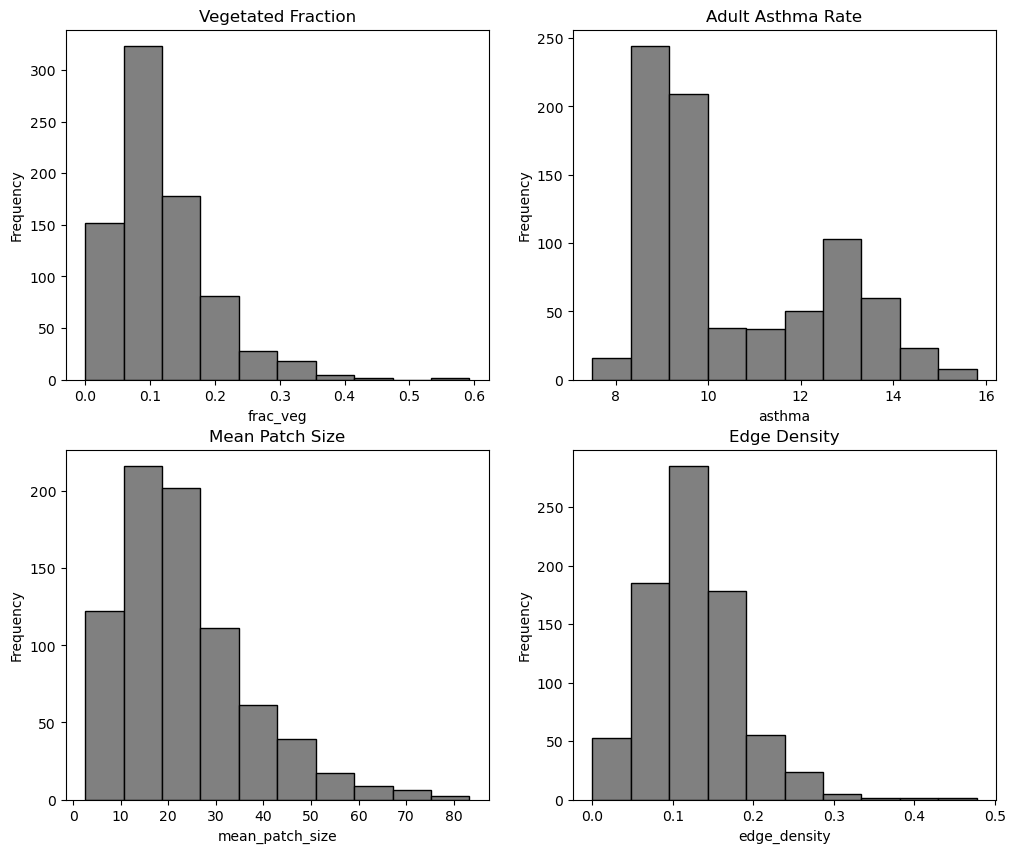

In [ ]:
## histograms

## make facet
fig, axes = plt.subplots(2, 2, figsize =(12, 10))

## list variables to plot
varibles = ['frac_veg', 'asthma', 'mean_patch_size', 'edge_density']
titles = ['Vegetated Fraction', 'Adult Asthma Rate', 'Mean Patch Size', 'Edge Density']

## loop through variables and axes to plot histograms
for i, (var, title) in enumerate(zip(varibles, titles)):
    ax = axes[i//2, i%2]
    ax.hist(chi_ndvi_cdc_gdf[var], bins = 10, color = 'gray', edgecolor = 'black')
    ax.set_title(title)
    ax.set_xlabel(var)
    ax.set_ylabel('Frequency')

## adjust layers to rpvent overlap
plt.tight_layout
plt.show()


In [114]:
## drop missing observations
model_df =(
    chi_ndvi_cdc_gdf

    ##make a copy
    .copy()

    ## subset to columns
    [['frac_veg', 'asthma', 'mean_patch_size', 'edge_density', 'geometry']]

    ## drop rows (observation) with missing value
    .dropna()
)

model_df

frac_veg  asthma  mean_patch_size  edge_density  \
0    0.178657    11.3        55.225919      0.118612   
1    0.233456    11.2        57.495962      0.161725   
2    0.186055    10.2        63.260250      0.123673   
3    0.191675    10.2        57.113642      0.126384   
4    0.173181    10.6        46.469309      0.128953   
..        ...     ...              ...           ...   
782  0.065849     9.5        13.665826      0.029140   
783  0.063240     9.7         7.649635      0.034699   
784  0.138652     9.5         6.197392      0.172915   
786  0.302037     8.5        22.553191      0.102765   
787  0.304724     9.2        19.844575      0.155318   

                                              geometry  
0    POLYGON ((-9758835.381 5164429.383, -9758837.3...  
1    POLYGON ((-9760143.496 5163888.741, -9760143.4...  
2    POLYGON ((-9759754.212 5163883.196, -9759726.6...  
3    POLYGON ((-9758695.229 5163870.91, -9758695.78...  
4    POLYGON ((-9757724.634 5160715.939, -9757742.2...  
..                                                 ...  
782  MULTIPOLYGON (((-9787333.178 5161561.245, -978...  
783  POLYGON ((-9780753.304 5157066.079, -9780752.0...  
784  POLYGON ((-9783235.84 5154620.343, -9783211.23...  
786  POLYGON ((-9768609.902 5160576.634, -9768654.5...  
787  MULTIPOLYGON (((-9774480.671 5161127.722, -977...  

[785 rows x 5 columns]

In [116]:
### Perform variable transformation

### log of asthma rate
model_df['log_asthma'] = np.log(model_df.asthma)

## log of patch size
model_df['log_patch'] = np.log(model_df.mean_patch_size)

model_df

frac_veg  asthma  mean_patch_size  edge_density  \
0    0.178657    11.3        55.225919      0.118612   
1    0.233456    11.2        57.495962      0.161725   
2    0.186055    10.2        63.260250      0.123673   
3    0.191675    10.2        57.113642      0.126384   
4    0.173181    10.6        46.469309      0.128953   
..        ...     ...              ...           ...   
782  0.065849     9.5        13.665826      0.029140   
783  0.063240     9.7         7.649635      0.034699   
784  0.138652     9.5         6.197392      0.172915   
786  0.302037     8.5        22.553191      0.102765   
787  0.304724     9.2        19.844575      0.155318   

                                              geometry  log_asthma  log_patch  
0    POLYGON ((-9758835.381 5164429.383, -9758837.3...    2.424803   4.011432  
1    POLYGON ((-9760143.496 5163888.741, -9760143.4...    2.415914   4.051715  
2    POLYGON ((-9759754.212 5163883.196, -9759726.6...    2.322388   4.147257  
3    POLYGON ((-9758695.229 5163870.91, -9758695.78...    2.322388   4.045043  
4    POLYGON ((-9757724.634 5160715.939, -9757742.2...    2.360854   3.838792  
..                                                 ...         ...        ...  
782  MULTIPOLYGON (((-9787333.178 5161561.245, -978...    2.251292   2.614898  
783  POLYGON ((-9780753.304 5157066.079, -9780752.0...    2.272126   2.034658  
784  POLYGON ((-9783235.84 5154620.343, -9783211.23...    2.251292   1.824129  
786  POLYGON ((-9768609.902 5160576.634, -9768654.5...    2.140066   3.115877  
787  MULTIPOLYGON (((-9774480.671 5161127.722, -977...    2.219203   2.987931  

[785 rows x 7 columns]

In [117]:
### Visualize transformed variables

hvplot.scatter_matrix(
    model_df[[
        'frac_veg',
        'edge_density',
        'log_patch',
        'log_asthma'
    ]]
)

:GridMatrix   [X,Y]
   :Histogram   [log_patch]   (Count)

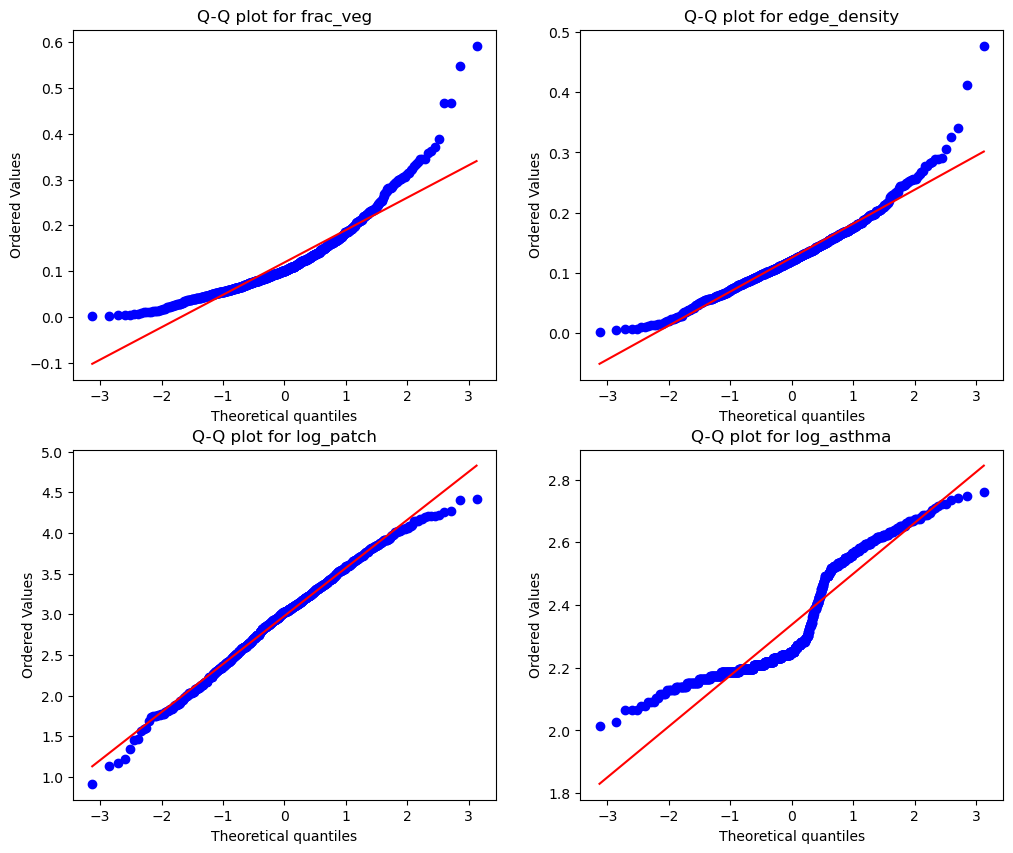

In [118]:
## make q-q plots


## set varaibles
var_qq = ['frac_veg', 'edge_density', 'log_patch', 'log_asthma']

## make q-q plot for each varaible
plt.figure(figsize = (12,10))
for i, var in enumerate(var_qq, 1):

    ## make 2X2 facets
    plt.subplot(2,2,i)

    ##normalize the distribution
    stats.probplot(model_df[var], dist = "norm", plot = plt)

    ## add title
    plt.title(f'Q-Q plot for {var}')

## plot it
plt.tight_layout
plt.show()

Reflect and respond: 
**EXPLAIN YOUR SELECTION AND TRANSFORMATION PROCESS HERE**

### Step 5b - Fit and Predict

If you have worked with statistical models before, you may notice that
the `scikitlearn` library has a slightly different approach than many
software packages. For example, `scikitlearn` emphasizes generic model
performance measures like cross-validation and importance over
coefficient p-values and correlation. The scikitlearn approach is meant
to generalize more smoothly to machine learning (ML) models where the
statistical significance is harder to derive mathematically.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>Use the scikitlearn documentation or ChatGPT as a starting point,
split your data into training and testing datasets.</li>
<li>Fit a linear regression to your training data.</li>
<li>Use your fitted model to predict the testing values.</li>
<li>Plot the predicted values against the measured values. You can use
the following plotting code as a starting point.</li>
</ol></div></div>

In [ ]:
### Select predictor and outcome variables

X = model_df[['edge_density', 'log_patch']]
y = model_df[['log_asthma']]

### Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(

    X, y, test_size = 0.33, random_state = 19
)

### Fit a linear regression

reg = LinearRegression()

## fit to our data

reg.fit(X_train, y_train)

### Predict asthma values for the test dataset

y_test['pred_asthma'] = np.exp(reg.predict(X_test))

## real asthma rate for comparsion
y_test['asthma'] = np.exp(y_test.log_asthma)

y_test



log_asthma  pred_asthma  asthma
296    2.197225     9.876208     9.0
602    2.595255    11.787206    13.4
642    2.595255    10.831441    13.4
379    2.240710    10.236403     9.4
16     2.302585    10.952168    10.0
..          ...          ...     ...
548    2.397895    10.767818    11.0
261    2.208274    10.143469     9.1
504    2.557227    10.931558    12.9
530    2.197225    10.407299     9.0
59     2.240710    10.272030     9.4

[260 rows x 3 columns]

In [124]:
### Plot measured vs. predicted asthma prevalence with a 1-to-1 line
y_max = y_test.asthma.max()
(
    y_test
    .hvplot.scatter(x='asthma', 
                    y='pred_asthma',
                    xlabel = "Measured adult asthma prevalance",
                    ylabel = "Predicted adult asthma prevalence",
                    title = "Linear regression performance - testing data"
                    
                    )
    .opts(aspect='equal', 
          xlim=(0, y_max), ylim=(0, y_max), 
          width=600, height=600)
) * hv.Slope(slope=1, y_intercept=0).opts(color='black')

:Overlay
   .Scatter.I    :Scatter   [asthma]   (pred_asthma)
   .Annotation.I :Slope   [x,y]

### Step 5c - Explore spatial bias

We always need to think about bias, or systematic error, in model
results. Every model is going to have some error, but we’d like to see
that error evenly distributed. When the error is systematic, it can be
an indication that we are missing something important in the model.

In geographic data, it is common for location to be a factor that
doesn’t get incorporated into models. After all – we generally expect
places that are right next to each other to be more similar than places
that are far away (this phenomenon is known as *spatial
autocorrelation*). However, models like this linear regression don’t
take location into account at all.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>Compute the model error (predicted - measured) for all census
tracts</li>
<li>Plot the error as a chloropleth map with a diverging color
scheme</li>
<li>Looking at both of your error plots, what do you notice? What are
some possible explanations for any bias you see in your model?</li>
</ol></div></div>

In [126]:
### Compute model error for all census tracts

## use the trained model to predict the asthma prevalence for each census tract

model_df['pred_asthma'] = np.exp(reg.predict(X))

## calculate model error

model_df['error_asthma'] = model_df['pred_asthma'] - model_df['asthma']

### Plot error geographically as a chloropleth
(

plot_chloropleth(model_df, color='error_asthma', cmap = 'RdBu')

## set frame width and aspect ratio
.opts(frame_width = 600, aspect = 'equal')

)


:Polygons   [Longitude,Latitude]   (frac_veg,asthma,mean_patch_size,edge_density,log_asthma,log_patch,pred_asthma,error_asthma)

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-respond"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Reflect and Respond</div></div><div class="callout-body-container callout-body"><p>What do you notice about your model from looking at the error plots?
What additional data, transformations, or model type might help improve
your results?</p></div></div>

**DESCRIBE AND INTERPRET YOUR IMAGE HERE**